In [2]:
import test_config as cfg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os, os.path
import pickle

In [3]:
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[0])
src = cv2.imread(src_fname)

In [165]:
src_s1 = cv2.resize(cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)/255, (768,1024))

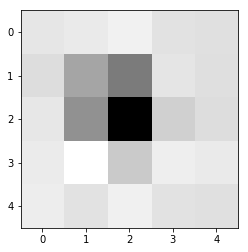

In [175]:
#source for filter
plt.imshow(src_s1[252:257,18:23], cmap='gray')

In [176]:
src_s1[252:257,18:23]

array([[0.78447074, 0.7877451 , 0.79461933, 0.78064108, 0.77899816],
       [0.77554381, 0.72362132, 0.68504902, 0.78347503, 0.77731694],
       [0.78473882, 0.70518919, 0.56983762, 0.76411229, 0.77602252],
       [0.78890548, 0.80781633, 0.75788143, 0.79199985, 0.78767233],
       [0.79096967, 0.78069087, 0.7935049 , 0.78047258, 0.77872626]])

In [61]:
def create_filter(kernel_size, dot_size):
    kernel = np.zeros((kernel_size, kernel_size))
    cx = kernel_size // 2
    kernel[(cx-dot_size):(cx+dot_size),(cx-dot_size):(cx+dot_size)]=1
    return kernel

In [185]:
def calc_l2(img, kernel):
    def get_l2(subimg, kernel):
        tmpimg = (subimg - np.mean(subimg))/np.std(subimg)
        diff = tmpimg-kernel
        return np.sqrt(np.mean(np.power(diff, 2.0)))
    (img_i, img_j) = img.shape
    (sz_i, sz_j) = kernel.shape
    return np.array([[get_l2(img[i:(i+sz_i),j:(j+sz_j)], kernel) for j in range(img_j-sz_j)] for i in range(img_i-sz_i)])

def calc_linf(img, kernel):
    def get_linf(subimg, kernel):
        tmpimg = (subimg - np.mean(subimg))/np.std(subimg)
        diff = np.abs(tmpimg-kernel)
        return np.max(diff)
    (img_i, img_j) = img.shape
    (sz_i, sz_j) = kernel.shape
    return np.array([[get_linf(img[i:(i+sz_i),j:(j+sz_j)], kernel) for j in range(img_j-sz_j)] for i in range(img_i-sz_i)])

In [184]:
#filter definition
flt = src_s1[252:257,18:23]
flt_nrm = (flt-np.mean(flt))/np.std(flt)

In [186]:
%%time
src_s2 = calc_linf(src_s1, flt)

Wall time: 48.1 s


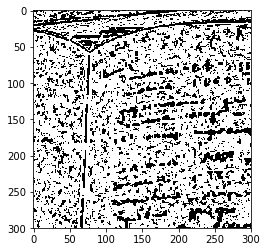

In [198]:
plt.imshow(src_s2[:300,:300]>2.5, cmap='gray')

L-infty does not seem to work

In [199]:
%%time
src_s2 = calc_l2(src_s1, flt)

Wall time: 57.1 s


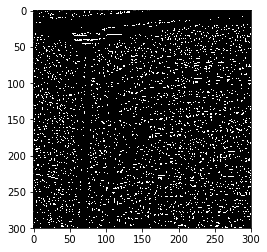

In [208]:
plt.imshow(src_s2[:300,:300]>1.27, cmap='gray')

L2 does not seem to work, either

In [249]:
def calc_features(img, kernel_size, inner_size):
    kernel = np.zeros((kernel_size, kernel_size))
    i_inner = (kernel_size - inner_size) // 2
    kernel[i_inner:(i_inner+inner_size), i_inner:(i_inner+inner_size)] = 1
    def get_features(subimg):
        tmp0 = subimg[kernel==0]
        tmp1 = subimg[kernel==1]
        return (np.mean(tmp0), np.std(tmp0), np.mean(tmp1), np.std(tmp1))
    (img_i, img_j) = img.shape
    return np.array([[get_features(img[i:(i+kernel_size),j:(j+kernel_size)]) for j in range(img_j-kernel_size)] for i in range(img_i-kernel_size)])

In [261]:
%%time
src_s3 = calc_features(src_s1, 6, 2)

Wall time: 1min 6s


In [262]:
src_s4 = -(src_s3[:,:,2]-src_s3[:,:,0]) / np.minimum(src_s3[:,:,1], 0.2)

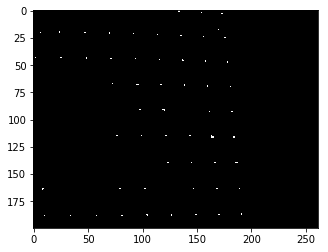

In [267]:
plt.imshow(src_s4[400:600,500:]>3.8, cmap='gray')

Seems to work!

In [270]:
grid = np.array([[(i, j) for j in range(src_s4.shape[1])] for i in range(src_s4.shape[0])])
points = grid[src_s4>3.8]

In [271]:
len(points)

1299

In [280]:
def get_closest_points(pnt, grd, src_value, value_cutoff, offset=50):
    min_i = max(0, pnt[0] - offset)
    min_j = max(0, pnt[1] - offset)
    max_i = min(src_value.shape[0], pnt[0] + offset)
    max_j = min(src_value.shape[1], pnt[1] + offset)
    tmp_grd = grd[min_i:max_i,min_j:max_j]
    tmp_val = src_value[min_i:max_i,min_j:max_j]
    return tmp_grd[tmp_val > value_cutoff]

In [352]:
def get_distances(pnt, pts):
    return np.array([np.sqrt(np.sum(np.power(pnt - x, 2.0))) for x in pts])

def get_all_vectors(pts):
    res = np.array([x-y for x in pts for y in pts if x[0]+x[1]>y[0]+y[1]])
    return (res, np.array([np.sqrt(np.dot(x,x)) for x in res]))

In [299]:
def select_distance(dsts, dst_cutoff=5):
    if np.sum(dsts>dst_cutoff) == 0:
        return np.nan
    return np.min(dsts[dsts>dst_cutoff])

In [278]:
tmp_s4 = src_s4[25:65,236:276]
tmp_grd = grid[25:65,236:276]

In [305]:
%%time
distances = np.array([select_distance(get_distances(x, get_closest_points(x, grid, src_s4, 3.8))) for x in points])

Wall time: 426 ms


In [307]:
np.percentile(distances[~np.isnan(distances)], [1,10,25, 50 ,75,90,99])

array([ 7.78807422, 17.64330636, 20.        , 21.48229574, 24.0208243 ,
       26.01922366, 33.94904961])

In [310]:
dst = int(np.ceil(np.percentile(distances[~np.isnan(distances)], 75)*3))

In [353]:
tmp, tmpd = get_all_vectors(get_closest_points(points[100], grid, src_s4, 3.8, dst))

In [370]:
tmp2u, tmp2c = np.unique([np.round(tmp[i]/np.round(x/21.48)) for (i,x) in enumerate(tmpd) if np.abs(x/21.48-np.round(x/21.48))<0.15 and x > 10], return_counts=True, axis=0)

In [478]:
def get_repers(vecs, lens, dst_med, err = 0.15):
    n_cutoff = len(vecs)//100
    res = []
    resn = []
    tmpv = np.array([np.round(x / np.round(d/dst_med)) for (x, d) in zip(vecs, lens) if np.abs((d/dst_med) - np.round(d/dst_med)) < err and d / dst_med > 0.5])
    while len(tmpv) > n_cutoff:
        tmpd = np.array([np.sqrt(np.dot(x, x)) for x in tmpv])
        d20 = np.percentile(tmpd, 20)
        u, c = np.unique(tmpv[tmpd <= d20], return_counts=True, axis=0)
        v = u[c==np.max(c)][0]
        #print(u, c)
        res.append(v)
        vl = np.sqrt(np.dot(v, v))
        vn = v / vl
        n1 = len(tmpv)
        tmpv = np.array([x for x in tmpv if np.abs(np.dot(vn,x/np.sqrt(np.dot(x,x)))) < 0.9])
        n0 = len(tmpv)
        resn.append(n1-n0)
    return res, resn

In [378]:
tmp2u, tmp2c = np.unique(tmp, return_counts=True, axis=0)

In [484]:
get_repers(tmp, tmpd, 21.48, err=0.3)[0][:2]

[array([19.,  2.]), array([ 3., 19.])]

In [436]:
points[100]

array([ 79, 642])

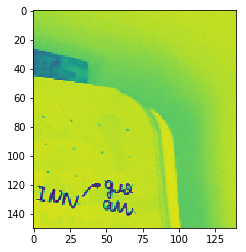

In [437]:
plt.imshow(src_s1[:150,580:720])

In [336]:
tmp3s1 = [x for x in tmp2 if np.sqrt(np.dot(x-tmp3v1, x-tmp3v1))>5]

In [338]:
tmp3s1u, tmp3s1c = np.unique(tmp3s1, return_counts=True, axis=0)

In [339]:
tmp3s1c

array([6, 2, 2, 3, 5, 1, 6, 9, 1, 1, 2], dtype=int64)

In [340]:
tmp3v2 = tmp3s1u[tmp3s1c==np.max(tmp3s1c)][0]

In [341]:
tmp3v2

array([19,  2])

In [342]:
tmp3v1

array([ 3, 19])

In [344]:
tmp

array([[  1,   0],
       [  3,  19],
       [  2,  19],
       [-16,  17],
       [  3,  20],
       [  2,  20],
       [  0,   1],
       [-16,  18],
       [-17,  18],
       [  4,  19],
       [  3,  19],
       [  1,   0],
       [-15,  17],
       [-16,  17],
       [  4,  20],
       [  3,  20],
       [  1,   1],
       [  1,   0],
       [  0,   1],
       [-15,  18],
       [-16,  18],
       [  6,  39],
       [  5,  39],
       [  3,  20],
       [  3,  19],
       [  2,  20],
       [  2,  19],
       [-13,  37],
       [-14,  37],
       [-16,  18],
       [-16,  17],
       [-32,  36],
       [-32,  35],
       [-33,  36],
       [-33,  35],
       [  9,  58],
       [  8,  58],
       [  6,  39],
       [  6,  38],
       [  5,  39],
       [  5,  38],
       [  3,  19],
       [-10,  56],
       [-11,  56],
       [-13,  37],
       [-13,  36],
       [-16,  18],
       [-16,  17],
       [-29,  55],
       [-29,  54],
       [-30,  55],
       [-30,  54],
       [-32,